<a href="https://colab.research.google.com/github/jr24abh/Airline-Fare-prediction/blob/main/Airline_Fare_Prediciction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Airfare Prediction Data Science Workflow
Project Title: Optimizing Airline Fare Prediction Using Ensemble Machine Learning Models
Dataset Source: Mendeley - MarketFarePredictionData.csv



Step 1: Project Setup and Goals
Objective:
Predict airline Average_Fare using both static and simulated dynamic features such as:

Days to departure

Departure day of week

Departure month
...to explore their influence on fare prediction.

Step 2: Data Upload and Sampling

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive/dataset


import pandas as pd

# If you uploaded to a subfolder: MyDrive/datasets/MarketFarePredictionData.csv
file_path = '/content/drive/MyDrive/dataset/MarketFarePredictionData (1).csv'

# Load and sample
df = pd.read_csv(file_path)
sample_df = df.sample(n=100000, random_state=42)

Mounted at /content/drive
'MarketFarePredictionData (1).csv'


 Step 3: Simulate Time-Based Columns
Simulate BookingDate and DepartureDate to create dynamic time features.


Simulate Time Columns:
Let’s simulate booking and departure dates so we can later create features like days_to_departure.

In [4]:
import numpy as np

# Simulate booking dates from Jan 1 to Sep 30, 2023
np.random.seed(42)
sample_df['BookingDate'] = pd.to_datetime(np.random.choice(
    pd.date_range(start="2023-01-01", end="2023-09-30"), size=sample_df.shape[0]
))

# Simulate realistic booking lead time (1–90 days to departure)
sample_df['DaysToDeparture'] = np.random.randint(1, 91, size=sample_df.shape[0])
sample_df['DepartureDate'] = sample_df['BookingDate'] + pd.to_timedelta(sample_df['DaysToDeparture'], unit='D')

# Extract additional time features
sample_df['DepartureMonth'] = sample_df['DepartureDate'].dt.month
sample_df['DepartureDayOfWeek'] = sample_df['DepartureDate'].dt.dayofweek


Step 4: Data Cleaning and Preprocessing

4.1 Drop Redundant Columns

In [5]:
# Drop columns not useful for prediction
drop_cols = ['BookingDate', 'DepartureDate']
sample_df = sample_df.drop(columns=drop_cols)

4.2 Encode Categorical Features

In [6]:
# Identify object columns (e.g., 'Carrier' if not numeric)
categorical = sample_df.select_dtypes(include='object').columns
sample_df[categorical] = sample_df[categorical].astype('category').apply(lambda x: x.cat.codes)

Step 5: Exploratory Data Analysis (EDA)

5.1 Basic Info

In [7]:
# Preview and structure
print("Shape of dataset:", sample_df.shape)
sample_df.head()

Shape of dataset: (100000, 29)


,MktCoupons,OriginCityMarketID,DestCityMarketID,OriginAirportID,DestAirportID,Carrier,NonStopMiles,RoundTrip,ODPairID,Pax,...,MktMilesFlown,OriginCityMarketID_freq,DestCityMarketID_freq,OriginAirportID_freq,DestAirportID_freq,Carrier_freq,ODPairID_freq,DaysToDeparture,DepartureMonth,DepartureDayOfWeek
115482,1,107,153,187,177,6,1501.0,1.0,2603,74417.0,...,1518.545060,0.015908,0.033257,0.015908,0.018680,0.116826,0.000582,70,6,3
1346404,2,159,152,160,194,20,1681.0,1.0,3570,125.0,...,1773.240506,0.001573,0.039783,0.001573,0.008368,0.307651,0.000050,58,11,5
1166331,1,127,110,111,158,1,618.0,1.0,2935,20746.0,...,611.263021,0.002198,0.066292,0.002198,0.021441,0.019013,0.000243,15,5,1
540157,1,58,239,44,244,20,549.0,1.0,1567,58431.0,...,528.097416,0.045310,0.002445,0.015105,0.002445,0.307651,0.000318,40,4,5
245966,1,152,152,97,255,19,2584.0,1.0,3390,88391.0,...,2639.138782,0.032488,0.039783,0.014188,0.022049,0.101671,0.001153,10,7,1


5.2 Check for Missing Values

In [8]:
# Check for nulls
print("Missing values:\n", sample_df.isnull().sum())

Missing values:
 MktCoupons                 0
OriginCityMarketID         0
DestCityMarketID           0
OriginAirportID            0
DestAirportID              0
Carrier                    0
NonStopMiles               0
RoundTrip                  0
ODPairID                   0
Pax                        0
CarrierPax                 0
Average_Fare               0
Market_share               0
Market_HHI                 0
LCC_Comp                   0
Multi_Airport              0
Circuity                   0
Slot                       0
Non_Stop                   0
MktMilesFlown              0
OriginCityMarketID_freq    0
DestCityMarketID_freq      0
OriginAirportID_freq       0
DestAirportID_freq         0
Carrier_freq               0
ODPairID_freq              0
DaysToDeparture            0
DepartureMonth             0
DepartureDayOfWeek         0
dtype: int64


5.3 Summary Statistics

In [9]:
# Describe numerical columns
sample_df.describe()

,MktCoupons,OriginCityMarketID,DestCityMarketID,OriginAirportID,DestAirportID,Carrier,NonStopMiles,RoundTrip,ODPairID,Pax,...,MktMilesFlown,OriginCityMarketID_freq,DestCityMarketID_freq,OriginAirportID_freq,DestAirportID_freq,Carrier_freq,ODPairID_freq,DaysToDeparture,DepartureMonth,DepartureDayOfWeek
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.179630,108.435240,108.605390,148.529870,149.435090,12.793020,1181.029300,0.807480,2493.080910,1.770362e+05,...,1211.774493,0.026541,0.026463,0.016564,0.016599,0.153479,0.000773,45.459900,6.510700,3.007760
std,0.387511,67.847674,68.231118,79.832136,80.014587,7.786739,709.787069,0.394281,1402.808781,2.377150e+05,...,723.226412,0.019320,0.019217,0.010069,0.010086,0.111799,0.000906,25.969804,2.733862,1.997689
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,102.000000,0.000000,0.000000,1.000000e+00,...,102.000000,0.000006,0.000004,0.000006,0.000004,0.000396,0.000002,1.000000,1.000000,0.000000
25%,1.000000,48.000000,48.000000,73.000000,74.000000,4.000000,642.000000,1.000000,1351.000000,3.150300e+04,...,657.883803,0.010375,0.010509,0.009313,0.008632,0.050863,0.000209,23.000000,4.000000,1.000000
50%,1.000000,107.000000,108.000000,150.000000,151.000000,15.000000,1011.000000,1.000000,2607.000000,8.654300e+04,...,1040.060556,0.026452,0.026206,0.016368,0.016721,0.116826,0.000464,45.000000,7.000000,3.000000
75%,1.000000,158.000000,159.000000,213.000000,214.000000,20.000000,1590.000000,1.000000,3502.000000,2.318210e+05,...,1638.297744,0.039787,0.039783,0.023245,0.023353,0.307651,0.001031,68.000000,9.000000,5.000000
max,3.000000,265.000000,267.000000,290.000000,291.000000,24.000000,5095.000000,1.000000,5353.000000,1.495396e+06,...,5096.520737,0.066924,0.066292,0.036302,0.035971,0.307651,0.005303,90.000000,12.000000,6.000000


5.4 Data Types

In [10]:
# Check column types
sample_df.dtypes

,0
MktCoupons,int64
OriginCityMarketID,int64
DestCityMarketID,int64
OriginAirportID,int64
DestAirportID,int64
Carrier,int64
NonStopMiles,float64
RoundTrip,float64
ODPairID,int64
Pax,float64


5.5 Distribution of Fares

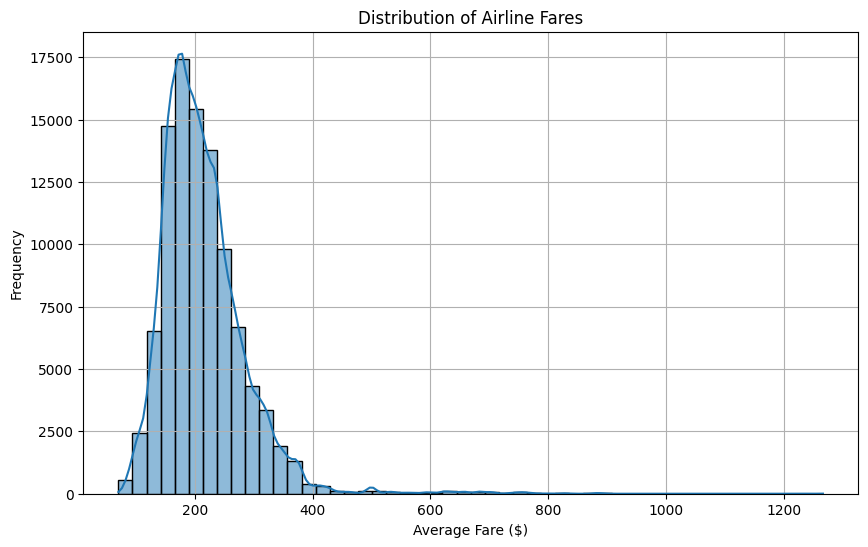

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(sample_df['Average_Fare'], bins=50, kde=True)
plt.title('Distribution of Airline Fares')
plt.xlabel('Average Fare ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

5.6 Correlation Heatmap

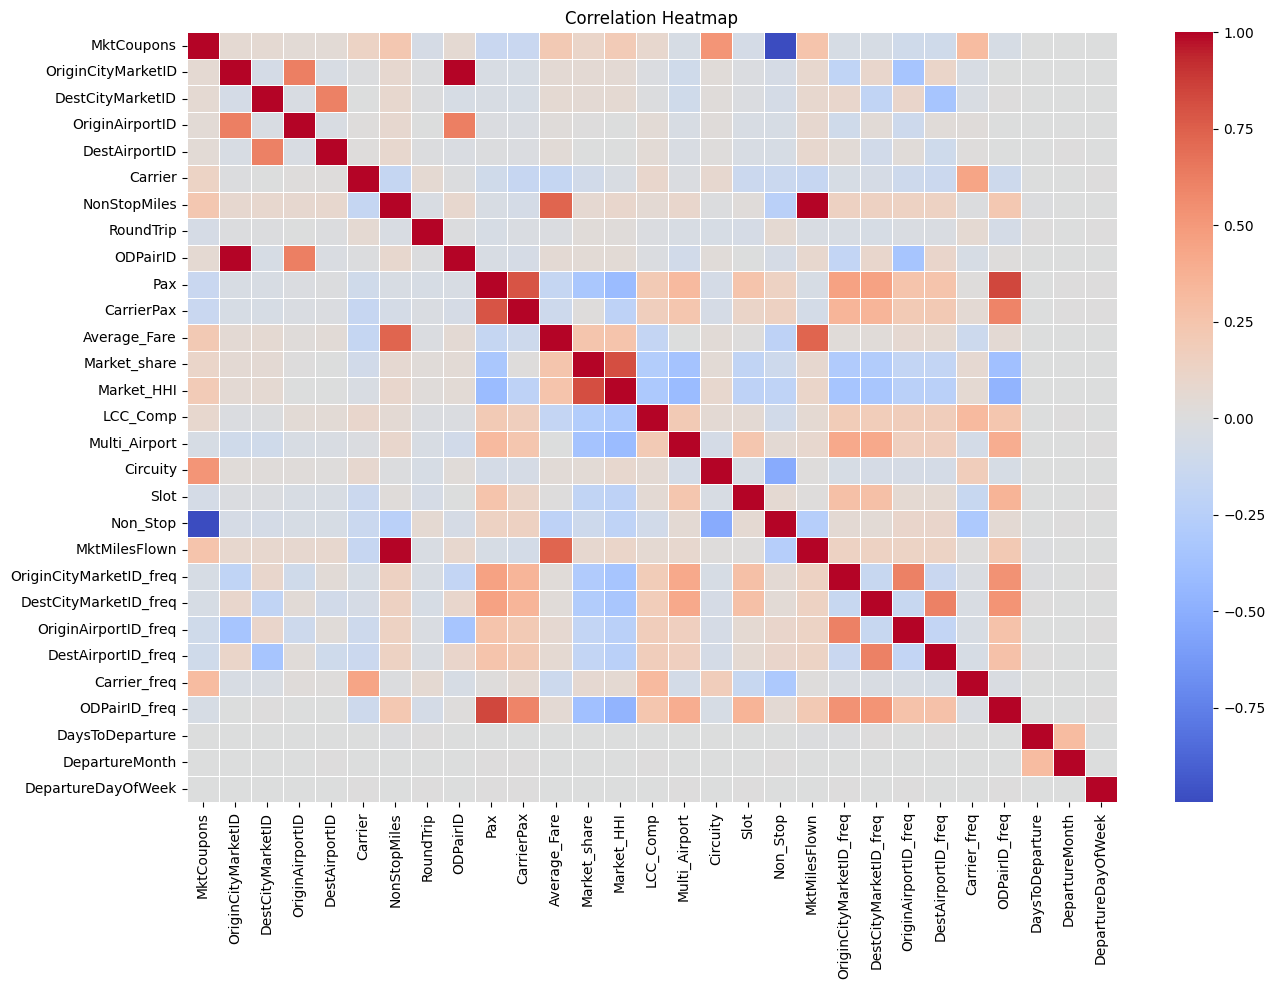

In [12]:
plt.figure(figsize=(15, 10))
sns.heatmap(sample_df.corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

5.7 Top Correlations with Fare

In [13]:
correlations = sample_df.corr()['Average_Fare'].sort_values(ascending=False)
print("Top correlated features with fare:\n", correlations.head(10))

Top correlated features with fare:
 Average_Fare            1.000000
NonStopMiles            0.732764
MktMilesFlown           0.732750
Market_HHI              0.257681
Market_share            0.245695
MktCoupons              0.218094
OriginAirportID_freq    0.068211
DestAirportID_freq      0.060725
DestCityMarketID        0.059382
ODPairID_freq           0.056578
Name: Average_Fare, dtype: float64


Step 6 :Feature Engineering

New Features Created:
FarePerMile: Derived by dividing Average_Fare by MktMilesFlown — this normalizes fare relative to distance.
LogFare: Natural logarithm of Average_Fare to reduce skew and stabilize variance.
Carrier Market Share Ratio: Proportion of passengers for the carrier vs. total passengers (CarrierPax / Pax).
IsWeekendDeparture: Binary feature to indicate whether the flight departs on a weekend.
IsLowCostCarrier: Re-encoded indicator based on presence in LCC_Comp.
These features aim to extract economic, behavioral, and time-dependent signals for better fare prediction.

We will evaluate whether these engineered features improve the model's accuracy (via R² and MSE) and feature importance rankings.

In [14]:
# Step 6: Additional Feature Engineering

import numpy as np

# 1. Fare per mile (normalize fare by distance)
sample_df['FarePerMile'] = sample_df['Average_Fare'] / sample_df['MktMilesFlown']
sample_df['FarePerMile'] = sample_df['FarePerMile'].replace([np.inf, -np.inf], np.nan)
sample_df['FarePerMile'] = sample_df['FarePerMile'].fillna(sample_df['FarePerMile'].median())

# 2. Log-transformed fare
sample_df['LogFare'] = np.log1p(sample_df['Average_Fare'])

# 3. Carrier market share
sample_df['CarrierShare'] = sample_df['CarrierPax'] / sample_df['Pax']
sample_df['CarrierShare'] = sample_df['CarrierShare'].replace([np.inf, -np.inf], np.nan)
sample_df['CarrierShare'] = sample_df['CarrierShare'].fillna(sample_df['CarrierShare'].median())

# 4. Weekend departure
sample_df['IsWeekendDeparture'] = sample_df['DepartureDayOfWeek'].apply(lambda x: 1 if x in [5, 6] else 0)

# 5. Low-Cost Carrier indicator
sample_df['IsLCC'] = sample_df['LCC_Comp'].apply(lambda x: 1 if x > 0 else 0)

Step 7: Feature Selection and Target Definition

In [15]:
# Define feature set and label
features_to_drop = ['Average_Fare', 'LogFare']  # Use LogFare as target separately if needed
X = sample_df.drop(columns=features_to_drop)
y = sample_df['Average_Fare']  # or y = sample_df['LogFare'] if you prefer predicting log-transformed fares


Step 8: Model Training (XGBoost)

In [16]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ MSE: {mse:.2f}")
print(f"✅ R² Score: {r2:.4f}")

✅ MSE: 10.69
✅ R² Score: 0.9980


Step 9: Visualize Feature Importance

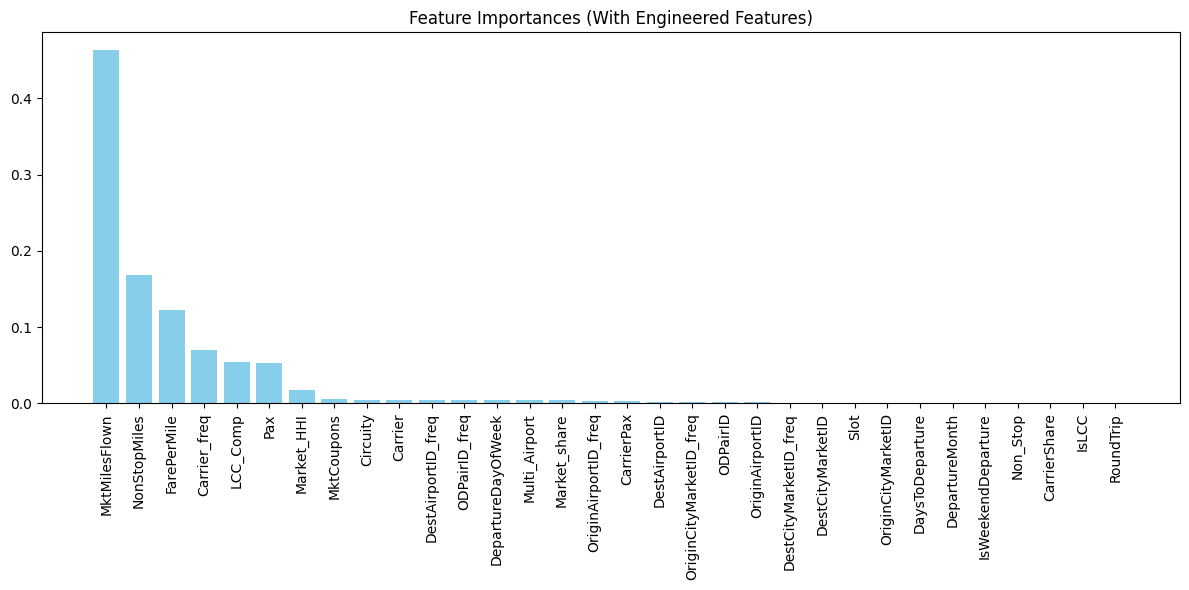

In [17]:
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances (With Engineered Features)")
plt.bar(range(X.shape[1]), importances[indices], color='skyblue')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()

Step 10: Compare More Models (CatBoost & Random Forest

In [18]:
# Train a Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

print(f" Random Forest MSE: {rf_mse:.2f}")
print(f" Random Forest R² Score: {rf_r2:.4f}")

 Random Forest MSE: 1.42
 Random Forest R² Score: 0.9997


In [19]:
# Train a Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

print(f" Random Forest MSE: {rf_mse:.2f}")
print(f" Random Forest R² Score: {rf_r2:.4f}")

 Random Forest MSE: 1.42
 Random Forest R² Score: 0.9997


Step 11: Compare All Model Results

In [20]:
print(" Model Comparison:")
print(f"XGBoost        MSE: {mse:.2f}, R²: {r2:.4f}")
print(f"Random Forest  MSE: {rf_mse:.2f}, R²: {rf_r2:.4f}")
print(f"CatBoost       MSE: {cat_mse:.2f}, R²: {cat_r2:.4f}")

 Model Comparison:
XGBoost        MSE: 10.69, R²: 0.9980
Random Forest  MSE: 1.42, R²: 0.9997


NameError: name 'cat_mse' is not defined

Step 12: Hyperparameter Tuning - XGBoost Regressor.

12.1.1 Import Libraries

In [21]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

12.1.2 Define Parameter Grid

In [22]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

12.1.3 Run Grid Search

In [23]:
xgb = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='r2',
    verbose=1,
    n_jobs=-1
)


12.1.4 Best Parameters & Model Performance

In [24]:
print(" Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

best_mse = mean_squared_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)

print(f" Tuned XGBoost MSE: {best_mse:.2f}")
print(f" Tuned XGBoost R² Score: {best_r2:.4f}")


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

12.1.5 Save the Best Model

In [25]:
import joblib

joblib.dump(best_model, 'best_xgboost_model.pkl')


NameError: name 'best_model' is not defined